# Linear Elasticity Fracture Mechanics

*Authors:* 
- *Laura De Lorenzis (ETH Zürich)*
- *Veronique Lazarus (ENSTA, IPP)*
- *Corrado Maurini (Sorbonne Université, corrado.maurini@sorbonne-universite.fr)*

This notebook serves as a tutorial for linear elastic fracture mechanics


In [1]:
import sys
sys.path.append("../utils")

# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import dolfinx.fem as fem
import dolfinx.mesh as mesh
import dolfinx.io as io
import dolfinx.plot as plot
import dolfinx.fem.petsc
import ufl

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType


plt.rcParams["figure.figsize"] = (6,3)

outdir = "output"
from pathlib import Path
Path(outdir).mkdir(parents=True, exist_ok=True)
sys.path.append("../../utils")



# Asymptotic field and SIF ($K_I$)

Let us first get the elastic solution for a given crack length 

Left edges found: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]                                                                              
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.002402s, CPU 0.002499s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0217473s, CPU 0.021513s)
Info    : 1174 nodes 2352 elements


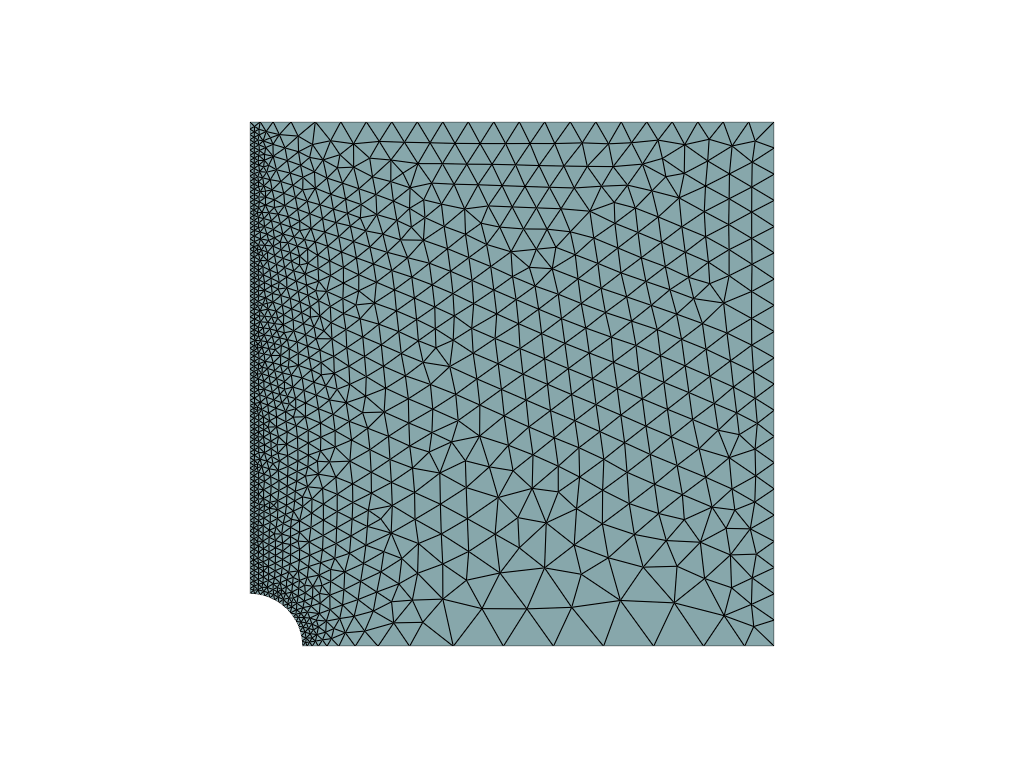

In [ ]:
import gmsh
from dolfinx.io import gmshio
import pyvista as pv
def create_rect_with_hole_crack(
    Lx=1.0, Ly=1.0,
    hole_center=(0.0, 0.0), hole_radius=0.1,
    split_y=0.5,      # y-coordinate where left edge is split
    mesh_size=0.05,
    refine_size_min=0.01, refine_size_max=0.1,
    refine_dist_min=0.02, refine_dist_max=0.2,
    plot=True,
    verbosity=1
):
    """
    Create a rectangle with a circular hole and split the left edge into two segments
    at y=split_y. The left edge segments are tagged separately as CrackBottom/CrackTop.
    Returns: (dolfinx.mesh.Mesh, cell_tags, facet_tags)
    """
    # initialize
    gmsh.initialize()
    gmsh.model.add("rect_with_split_crack_stable")
    gmsh.option.setNumber("General.Terminal", verbosity)  # 1: normal, 2: verbose, 0: silent
    # ---- 1) Build rectangle explicitly so we control the left edge id ----
    p1 = gmsh.model.occ.addPoint(0.0, 0.0, 0.0, mesh_size)   # (0,0)
    p2 = gmsh.model.occ.addPoint(0.0, Ly, 0.0, mesh_size)    # (0,Ly)
    p3 = gmsh.model.occ.addPoint(Lx, Ly, 0.0, mesh_size)    # (Lx,Ly)
    p4 = gmsh.model.occ.addPoint(Lx, 0.0, 0.0, mesh_size)   # (Lx,0)

    l_left  = gmsh.model.occ.addLine(p1, p2)   # left edge (we keep this id)
    l_top   = gmsh.model.occ.addLine(p2, p3)
    l_right = gmsh.model.occ.addLine(p3, p4)
    l_bottom= gmsh.model.occ.addLine(p4, p1)

    cl = gmsh.model.occ.addCurveLoop([l_left, l_top, l_right, l_bottom])
    rect_surf = gmsh.model.occ.addPlaneSurface([cl])

    gmsh.model.occ.synchronize()

    # ---- 2) Add a split point on the left edge and fragment the rectangle surface with it
    # This splits the left boundary into two edges while the rectangle's topology is stable.
    p_split = gmsh.model.occ.addPoint(0.0, split_y, 0.0, mesh_size/2.0)
    gmsh.model.occ.synchronize()

    # fragment the rectangle surface by the point -> will split boundary curves
    gmsh.model.occ.fragment([(2, rect_surf)], [(0, p_split)])
    gmsh.model.occ.synchronize()

    # ---- 3) Add circular hole and cut it out ----
    cx, cy = hole_center
    hole = gmsh.model.occ.addDisk(cx, cy, 0.0, hole_radius, hole_radius)
    gmsh.model.occ.synchronize()

    # cut the hole from the (already fragmented) surface
    res = gmsh.model.occ.cut([(2, rect_surf)], [(2, hole)], removeObject=True, removeTool=True)
    gmsh.model.occ.synchronize()

    # after cut, there may be new surface ids; collect all 2D surfaces that remain (domain pieces)
    surfaces = [s for s in gmsh.model.getEntities(dim=2)]

    # ---- 4) Define physical groups for boundary conditions ----
    left_edges = [1,6,5]
    
    # Domain: all 2D surfaces
    if surfaces:
        gmsh.model.addPhysicalGroup(2, [s[1] for s in surfaces], tag=1)
        gmsh.model.setPhysicalName(2, 1, "Domain")
    
    # ---- 6) Mesh size / refinement field near the left edges ----
    # Set a coarse global size first (already set by point sizes, but explicit is fine)
    # create Distance field from the left edges
    if left_edges:
        gmsh.model.mesh.field.add("Distance", 1)
        gmsh.model.mesh.field.setNumbers(1, "EdgesList", left_edges)

        gmsh.model.mesh.field.add("Threshold", 2)
        gmsh.model.mesh.field.setNumber(2, "InField", 1)
        gmsh.model.mesh.field.setNumber(2, "SizeMin", refine_size_min)
        gmsh.model.mesh.field.setNumber(2, "SizeMax", refine_size_max)
        gmsh.model.mesh.field.setNumber(2, "DistMin", refine_dist_min)
        gmsh.model.mesh.field.setNumber(2, "DistMax", refine_dist_max)
        gmsh.model.mesh.field.setAsBackgroundMesh(2)

    # ---- 7) Generate mesh ----
    gmsh.model.mesh.generate(2)

    # ---- 8) Export to dolfinx mesh ----
    domain, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0,gdim=2)

    # Optional plot with pyvista
    if plot:
        import dolfinx.plot
        grid = pv.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain))
        plt = pv.Plotter()
        plt.add_mesh(grid, show_edges=True)
        plt.camera_position = "xy"
        plt.show()

    # finalize gmsh (keep return values for the caller)
    gmsh.finalize()
    return domain, cell_tags, facet_tags


domain, cell_tags, facet_tags = create_rect_with_hole_crack(Lx=1.0, Ly=1.0, hole_center=(0.0,0.0), hole_radius=0.1, split_y=0.25, plot=True
     )

Left edges found: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
The potential energy for Lcrack=3.000e-01 is -5.122e-01


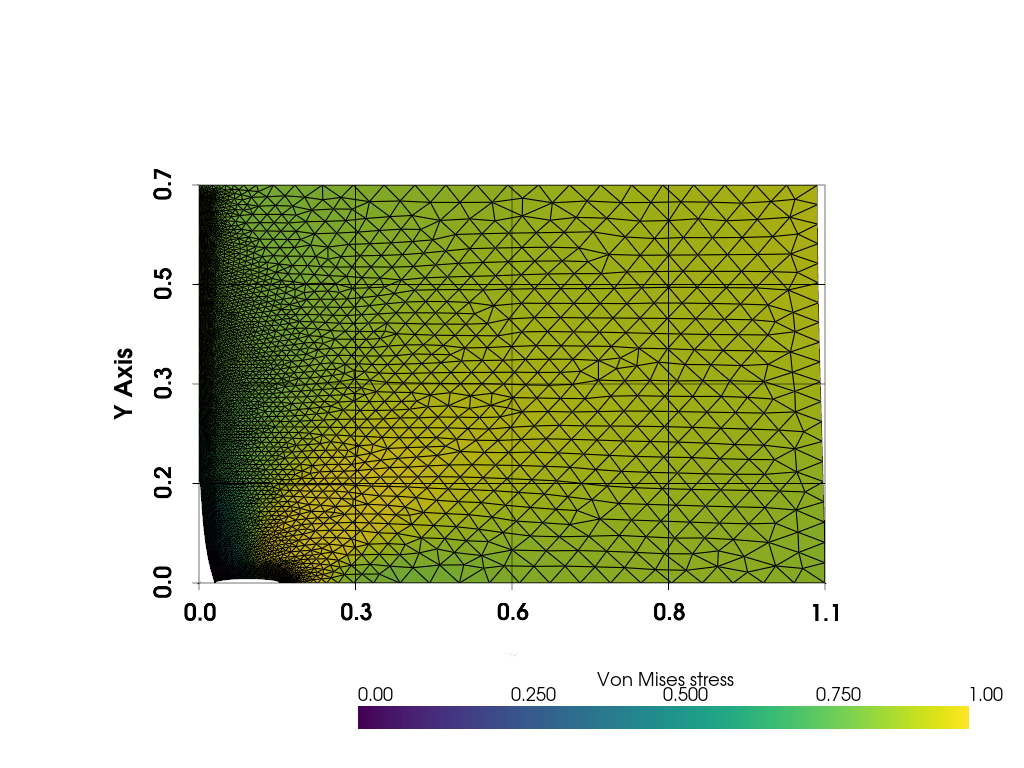

In [42]:

def solve_elasticity(
    nu=0.3,
    E=1,
    load=1,
    Lx=1,
    Ly=0.5,
    Lcrack=0.3,
    hole_radius=0.1,
    lc=0.1,
    refinement_ratio=10,
    dist_min=0.2,
    dist_max=0.3,
    verbosity=0,
):
    msh, mt, ft = create_rect_with_hole_crack(
        Lx=Lx, Ly=Ly, 
        hole_center=(0.0,0.0), 
        hole_radius=hole_radius, 
        split_y=Lcrack, plot=False,
        mesh_size=lc, verbosity=verbosity, 
        refine_size_min=lc/refinement_ratio, refine_size_max=lc,
     )

    V = fem.functionspace(msh, ("Lagrange", 1, (2,)))

    def left_no_crack(x):
        return np.logical_and(np.isclose(x[0], 0.0), x[1] > Lcrack)

    def bottom(x):
        return np.isclose(x[1], 0)
    
    def top(x):
        return np.isclose(x[1], Ly)

    left_no_crack_facets = mesh.locate_entities_boundary(
        msh, msh.topology.dim - 1, left_no_crack
    )
    left_no_crack_dofs_x = fem.locate_dofs_topological(
        V.sub(0), msh.topology.dim - 1, left_no_crack_facets
    )

    bottom_facets = mesh.locate_entities_boundary(
        msh, msh.topology.dim - 1, bottom
    )
    bottom_dofs_x = fem.locate_dofs_topological(
        V.sub(1), msh.topology.dim - 1, bottom_facets
    )
    bc_bottom = fem.dirichletbc(ScalarType(0), bottom_dofs_x, V.sub(1))
    bc_left = fem.dirichletbc(ScalarType(0), left_no_crack_dofs_x, V.sub(0))
    top_facets = mesh.locate_entities_boundary(
        msh, msh.topology.dim - 1, top
    )
    top_dofs_x = fem.locate_dofs_topological(
        V.sub(1), msh.topology.dim - 1, top_facets
    )
    bc_top = fem.dirichletbc(ScalarType(load), top_dofs_x, V.sub(1))
    bcs = [bc_bottom, bc_left, bc_top]

    dx = ufl.Measure("dx", domain=msh)
    top_facets = mesh.locate_entities_boundary(
        msh, 1, top
    )
    mt = mesh.meshtags(msh, 1, top_facets, 1)
    ds = ufl.Measure("ds", subdomain_data=mt)

    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    # this is for plane-stress
    lmbda = 2 * mu * lmbda / (lmbda + 2 * mu)

    def eps(u):
        """Strain"""
        return ufl.sym(ufl.grad(u))

    def sigma(eps):
        """Stress"""
        return 2.0 * mu * eps + lmbda * ufl.tr(eps) * ufl.Identity(2)

    def a(u, v):
        """The bilinear form of the weak formulation"""
        return ufl.inner(sigma(eps(u)), eps(v)) * dx

    def L(v):
        """The linear form of the weak formulation"""
        # Volume force
        b = fem.Constant(msh, ScalarType((0, 0)))

        # Surface force on the top
        f_y=load
        f = fem.Constant(msh, ScalarType((0, f_y)))
        return ufl.dot(b, v) * dx + ufl.dot(f, v) * ds(1)

    problem = fem.petsc.LinearProblem(
        a(u, v),
        L(v),
        bcs=bcs,
        petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
    )
    uh = problem.solve()
    uh.name = "displacement"

    energy = fem.assemble_scalar(fem.form(0.5 * a(uh, uh) - L(uh)))
    print(f"The potential energy for Lcrack={Lcrack:2.3e} is {energy:2.3e}")
    sigma_ufl = sigma(eps(uh))
    return uh, energy, sigma_ufl


Lx = 1.
Ly = 1.
Lcrack = 0.3
lc =.05
dist_min = .1
dist_max = .3
hole_radius=0.1
uh, energy, sigma_ufl = solve_elasticity(Lx=Lx,
                                         Ly=Ly,
                                         load =-1.0,
                                         Lcrack=Lcrack,
                                         lc=lc,
                                         refinement_ratio=20,
                                         dist_min=dist_min,
                                         dist_max=dist_max,
                                         hole_radius=hole_radius,
                                         verbosity=0)

from plots import warp_plot_2d
import pyvista
pyvista.set_jupyter_backend("static")
pyvista.start_xvfb()

import ufl
sigma_iso = 1./3*ufl.tr(sigma_ufl)*ufl.Identity(len(uh))
sigma_dev =  sigma_ufl - sigma_iso
von_Mises = ufl.sqrt(3./2*ufl.inner(sigma_dev, sigma_dev))
V_dg = fem.functionspace(uh.function_space.mesh, ("DG", 0))
stress_expr = fem.Expression(von_Mises, V_dg.element.interpolation_points())
vm_stress = fem.Function(V_dg)
vm_stress.interpolate(stress_expr)

plotter = warp_plot_2d(uh,cell_field=vm_stress,field_name="Von Mises stress", factor=.3,show_edges=True,clim=[0.0, 1.0],show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter.show_grid()
    plotter.show()
else:
    figure = plotter.screenshot(f"{outdir}/VonMises.png")

As detailed in the lectures notes, we can estimate the value of the stress intensity factor $K_I$ by extrapolating $u \sqrt{2\pi/ r}$

We estimate $K_I\simeq 1.8\pm0.1$

## Stress at the crack tip

Let us get the stress around the crack tip

As detailed in the lectures notes, we can estimate the value of the stress intensity factor $K_I$ by extrapolating $\sigma_{rr} \sqrt{2\pi r}$

We can say that $K_I\simeq 1.5\pm .5$ as from the COD, but this estimate is not precise and reliable. 

From Irwin's formula in plane-stress, we get the energy release rate (ERR)


# The elastic energy release rate 

## Naïf method: finite difference of the potential energy

Let us first calculate the potential energy for several crack lengths. We multiply the result by `2`` to account for the symmetry when comparing with the $K_I$ estimate above.

In [35]:
Ls = np.linspace(.1,.95 * Ly,50)
energies = np.zeros_like(Ls)
Gs = np.zeros_like(Ls)
for (i, L) in enumerate(Ls):
    uh, energies[i], _ = solve_elasticity(Lx=Lx,
                                          Ly=Ly,
                                          Lcrack=L,
                                          hole_radius=.1,
                                          lc=.05,
                                          refinement_ratio=10,
                                          dist_min=.1,
                                          dist_max=1.,
                                          verbosity=0)
    
energies = energies * 2

Left edges found: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
The potential energy for Lcrack=1.000e-01 is -5.116e-01
Left edges found: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
The potential energy for Lcrack=1.173e-01 is -5.117e-01
Left edges found: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
The potential energy for Lcrack=1.347e-01 is -5.119e-01
Left edges found: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
The potential energy for Lcrack=1.520e-01 is -5.120e-01
Left edges found: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
The potential energy for Lcrack=1.694e-01 is -5.120e-01
Left edges found: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
The potential energy for Lcrack=1.867e-01 is -5.121e-01
Left edges found: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
The potential energy for Lcrack=2.041e-01 is -5.121e-01
Left edges found: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
The potential energy for Lcrack=2.214e-01 is -5.121e-01
Left edges found: [(1, 1

We can estimate the ERR by taking the finite-difference approximation of the derivative

[]

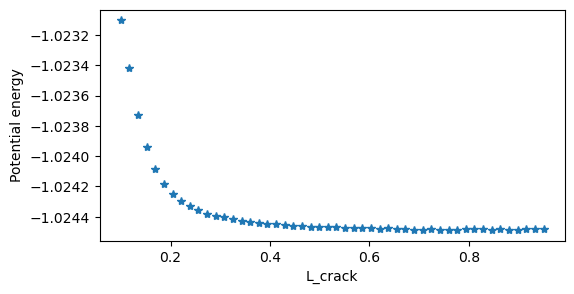

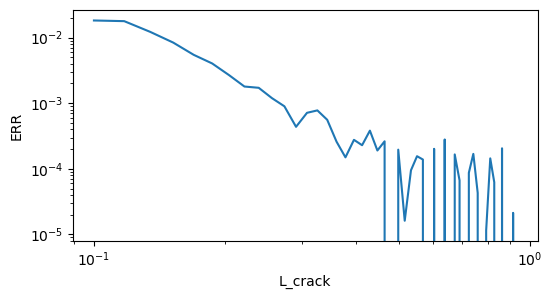

In [37]:
ERR_naif = -np.diff(energies)/np.diff(Ls)

plt.figure()
plt.plot(Ls, energies,"*")
plt.xlabel("L_crack")
plt.ylabel("Potential energy")
plt.figure()
plt.plot(Ls[0:-1], ERR_naif,"-")
plt.ylabel("ERR")
plt.xlabel("L_crack")
plt.loglog()

# G-theta method: domain derivative
This function implement the G-theta method to compte the ERR as described in the lecture notes (see https://gitlab.com/newfrac/CORE-school/newfrac-core-numerics/-/blob/master/Core_School_numerical_NOTES.pdf?ref_type=heads).

We first create by an auxiliary computation a suitable theta-field.

To this end, we solve an auxiliary problem for finding a $\theta$-field which is equal to $1$ in a disk around the crack tip and vanishing on the boundary.
This field defines the "direction" for the domain derivative, which should change the crack length, but not the outer boundary.  

Here we determine the $\theta$ field by solving the following problem

$$
\Delta \theta = 0\quad \text{for}\quad x\in\Omega,
\quad \theta=1\quad \text{for} \quad x\in \mathrm{D}\equiv\{\Vert x-x_\mathrm{tip}\Vert<R_{\mathrm{int}}\},
\quad \theta=0\quad \text{for} \quad x\in\partial\Omega, \;\Vert x-x_\mathrm{tip}\Vert>R_{\mathrm{ext}}
$$

This is implemented in the function below

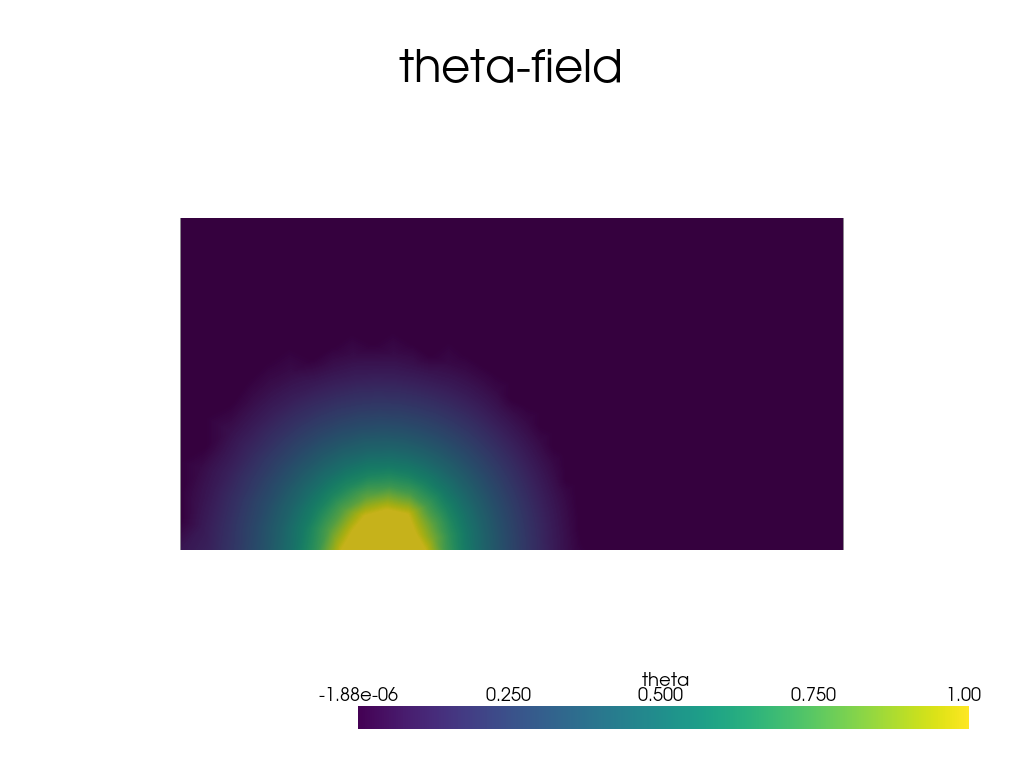

In [33]:
def create_theta_field(domain,crack_tip,R_int,R_ext):
    
    def tip_distance(x):
          return np.sqrt((x[0]-crack_tip[0])**2 + (x[1]-crack_tip[1])**2) 
    
    V_theta = fem.functionspace(domain,("Lagrange",1))
    
   
    # Define variational problem to define the theta-field. 
    # We solve a simple laplacian
    theta, theta_ = ufl.TrialFunction(V_theta), ufl.TestFunction(V_theta)
    a = ufl.dot(ufl.grad(theta), ufl.grad(theta_)) * ufl.dx
    L = fem.Constant(domain,ScalarType(0.)) * theta_ * ufl.dx(domain=domain) 

    # Set the BCs
    # Imposing 1 in the inner circle and zero in the outer circle
    dofs_inner = fem.locate_dofs_geometrical(V_theta,lambda x : tip_distance(x) < R_int)
    dofs_out = fem.locate_dofs_geometrical(V_theta,lambda x : tip_distance(x) > R_ext)
    bc_inner = fem.dirichletbc(ScalarType(1.),dofs_inner,V_theta)
    bc_out = fem.dirichletbc(ScalarType(0.),dofs_out,V_theta)
    bcs = [bc_out, bc_inner]

    # solve the problem
    problem = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "gmres", "pc_type": "gamg"})
    thetah = problem.solve()
    return thetah

crack_tip = np.array([Lcrack,0])
crack_tangent = np.array([1,0])
crack_tip = np.array([Lcrack,0])
R_int = Lcrack/4.
R_ext = Lcrack
domain = uh.function_space.mesh
thetah = create_theta_field(domain,crack_tip,R_int,R_ext)


# Plot theta
topology, cell_types, geometry = plot.vtk_mesh(thetah.function_space)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
grid.point_data["theta"] = thetah.x.array.real
grid.set_active_scalars("theta")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=False)
plotter.add_title("theta-field")
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()

From the scalar field, we define a vector field by multiplying by the tangent vector to the crack: t=[1,0]

Hence, we can compute the ERR with the formula
$$
G  = \int_\Omega \left(\sigma(\varepsilon(u))\cdot(\nabla u\nabla\theta)-\dfrac{1}{2}\sigma(\varepsilon(u))\cdot \varepsilon(u) \mathrm{div}(\theta)\,\right)\mathrm{dx}$$

In [34]:
Lx = 1.
Ly = 0.5
Lcrack = 0.3
crack_tip = np.array([Lcrack,0])
crack_tangent = np.array([1,0])
crack_tip = np.array([Lcrack,0])
R_int = Lcrack/4
R_ext = Lcrack
uh, energy, sigma_ufl = solve_elasticity(Lx=Lx,Ly=Ly,Lcrack=Lcrack,lc=.05,refinement_ratio=30,dist_min=.1,dist_max=1.0)

thetah = create_theta_field(uh.function_space.mesh,crack_tip,R_int,R_ext)
eps_ufl = ufl.sym(ufl.grad(uh))
theta_vector = ufl.as_vector([1.,0.]) * thetah
dx = ufl.dx(domain=uh.function_space.mesh)
first_term = ufl.inner(sigma_ufl,ufl.grad(uh) * ufl.grad(theta_vector)) * dx
second_term = - 0.5 * ufl.inner(sigma_ufl,eps_ufl) * ufl.div(theta_vector) * dx

G_theta = 2 * fem.assemble_scalar(fem.form(first_term + second_term))
print(f'The ERR computed with the G-theta method is {G_theta:2.4f}' )

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00677896s, CPU 0.006118s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.246177s, CPU 0.24425s)
Info    : 13064 nodes 26131 elements
The potential energy for Lcrack=3.000e-01 is -4.112e-01
The ERR computed with the G-theta method is 3.0315


**Note:**
The $\theta$ field represents how the domain is "varied" to take the domain derivative. It must be 1 on the tip and zero on the boundary of the domain. The choice of the field is otherwise arbritrary. With the generation method above, given the crack length `Lcrack`, the disk radius `Rext` should be chosen such that the disk does not intersect the boundary of the domain: `Rext < Lcrack`. The internal radius `Rint` can be chosen as few time the mesh size at the tip, for example.